In [2]:
from typing import Sequence, Union
import os
import sys
import glob
import itertools
from datetime import datetime
from pprint import pprint
from tqdm import tqdm
import joblib

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
from scipy import linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.distributions
import pytorch_lightning as pl

import src
from src.attrs import PATHS, GLOBALS
from src import utils

from src.data import loading
from src.train import datasets, losses
from src.models import base, koopman_autoencoder, cnn
from src.tools import plot

~/.conda/envs/koopman/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
plt.style.use('custom.mplstyle')

shared_kwargs = {'alpha': 0.8, 'lw': 1.5}
pca_kwargs = {'color': 'C0'}
cae_kwargs = {'color': 'C3'}
dp_kwargs = {'ls': '-', 'marker': 'o', 'markerfacecolor': '#EEEEEE', 'zorder': 1}
lim_kwargs = {'ls': '-', 'marker': 'o', 'zorder': 2}
kae_kwargs = {'color': 'C1', 'marker': 'x', 'mew': 2, 'zorder': 3}


# D = 20 daily subsampled data

In [4]:
models = [
    'PCA + LIM',
    'CAE + LIM',
    'PCA + DP',
    'CAE + DP',
    'KAE',
]

filenames = [
    'lim_pca_ssh_d20_best',
    'lim_cae_ssh_d20_best',
    'dp_pca_ssh_d20_best',
    'dp_cae_ssh_d20_best',
    'kae_ssh_d20',
]

kwargs_list = [
    {**pca_kwargs, **lim_kwargs, **shared_kwargs},
    {**cae_kwargs, **lim_kwargs, **shared_kwargs},
    {**pca_kwargs, **dp_kwargs, **shared_kwargs},
    {**cae_kwargs, **dp_kwargs, **shared_kwargs},
    {**kae_kwargs, **shared_kwargs},
]

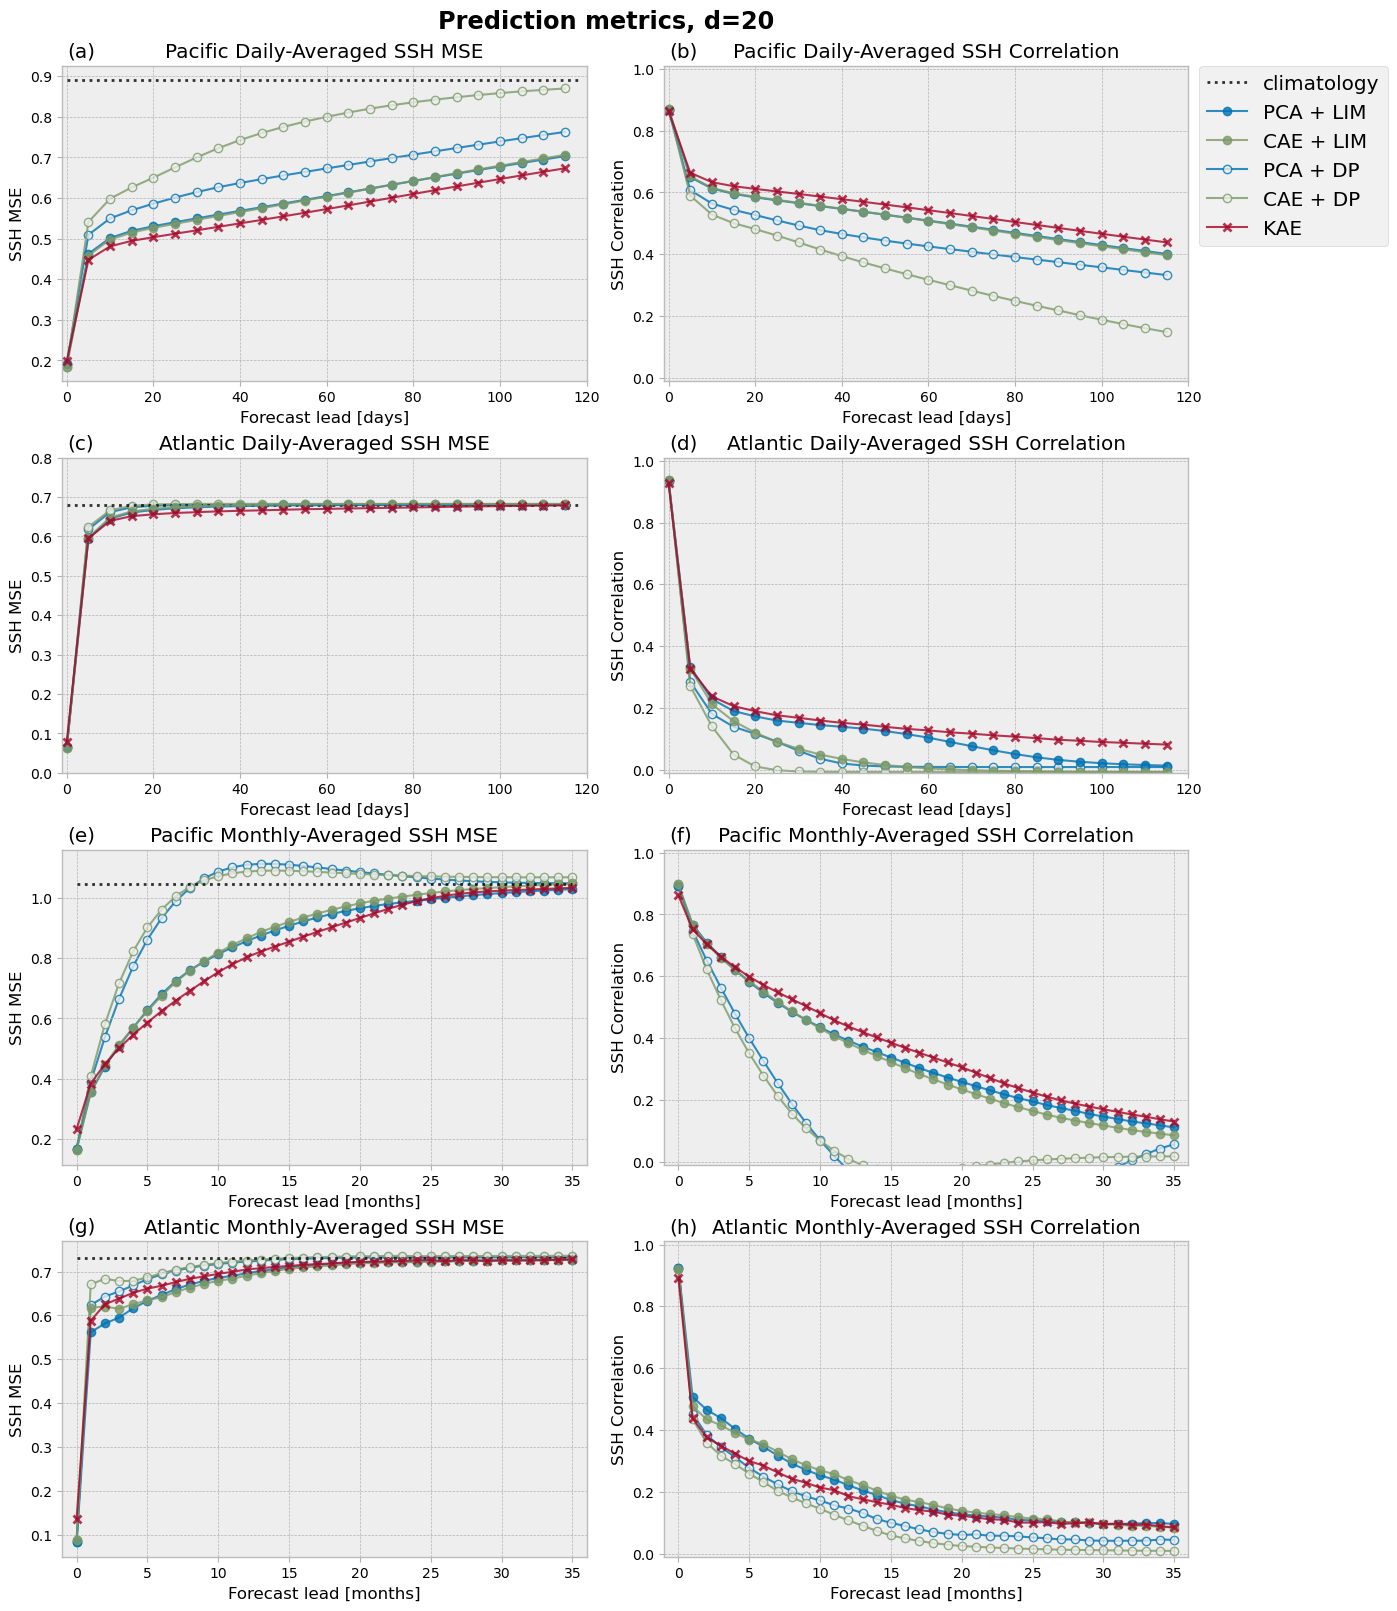

In [5]:
fig, axes = plt.subplot_mosaic(
    np.array(list('abcdefgh')).reshape(4,2),
    figsize=(12,16),
    layout='constrained'
)


####################################################################################
# Daily 

SUBPROJECT = 'cnn_pacific_daily_subsampled'

N_ITER = 120

# MSE
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
clim_mse = xr.open_dataarray(os.path.join(metrics_path, f'clim_global_mse.nc'))
clim_mse = clim_mse.sel(variable="SSH") * xr.DataArray(np.ones(N_ITER), coords={'lag': np.arange(N_ITER)})
clim_mse.plot(ax=axes['a'], ls=':', color='k', zorder=5, alpha=shared_kwargs['alpha'], label='climatology')

# Reset metrics path
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
# MSE plots
for (model, fname, kwargs) in zip(models, filenames, kwargs_list):
    mse = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_mse.nc'))
    mse.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['a'], label=model, **kwargs)

    corr = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_corr.nc'))
    corr.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['b'], **kwargs)

# SSH daily, North Pacific, D=50
SUBPROJECT = 'cnn_north_atlantic_daily_subsampled'

N_ITER = 120

# MSE
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
clim_mse = xr.open_dataarray(os.path.join(metrics_path, f'clim_global_mse.nc'))
clim_mse = clim_mse.sel(variable="SSH") * xr.DataArray(np.ones(N_ITER), coords={'lag': np.arange(N_ITER)})
clim_mse.plot(ax=axes['c'], ls=':', color='k', alpha=shared_kwargs['alpha'])

# Reset metrics path
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
# MSE plots
for (model, fname, kwargs) in zip(models, filenames, kwargs_list):
    mse = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_mse.nc'))
    mse.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['c'], **kwargs)

    corr = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_corr.nc'))
    corr.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['d'], **kwargs)

####################################################################################
# Monthly stuff

SUBPROJECT = 'cnn_pacific_monthly'

N_ITER = 36

# MSE
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
clim_mse = xr.open_dataarray(os.path.join(metrics_path, f'clim_global_mse.nc'))
clim_mse = clim_mse.sel(variable="SSH") * xr.DataArray(np.ones(N_ITER), coords={'lag': np.arange(N_ITER)})
clim_mse.plot(ax=axes['e'], ls=':', color='k', zorder=5, alpha=shared_kwargs['alpha'])

# Reset metrics path
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
# MSE plots
for (model, fname, kwargs) in zip(models, filenames, kwargs_list):
    try:
        mse = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_mse.nc'))
        mse.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['e'], **kwargs)

        corr = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_corr.nc'))
        corr.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['f'], **kwargs)
    except:
        pass

###########################################################################################
SUBPROJECT = 'cnn_north_atlantic_monthly'

N_ITER = 36

# MSE
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
clim_mse = xr.open_dataarray(os.path.join(metrics_path, f'clim_global_mse.nc'))
clim_mse = clim_mse.sel(variable="SSH") * xr.DataArray(np.ones(N_ITER), coords={'lag': np.arange(N_ITER)})
clim_mse.plot(ax=axes['g'], ls=':', color='k', alpha=shared_kwargs['alpha'])

# Reset metrics path
metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
# MSE plots
for (model, fname, kwargs) in zip(models, filenames, kwargs_list):
    mse = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_mse.nc'))
    mse.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['g'], **kwargs)

    corr = xr.open_dataarray(os.path.join(metrics_path, f'{fname}_global_corr.nc'))
    corr.sel(variable='SSH').isel(lag=slice(0,N_ITER)).plot(ax=axes['h'], **kwargs)


####################################################################################
# Axes properties

axes['a'].set(
    title='Pacific Daily-Averaged SSH MSE',
    xlim=(-1,120), 
    # ylim=(0.2, 0.8),
    xlabel='Forecast lead [days]',
    ylabel='SSH MSE'
)

axes['b'].set(
    title='Pacific Daily-Averaged SSH Correlation',
    xlim=(-1,120),
    ylim=(-0.01, 1.01), 
    xlabel='Forecast lead [days]',
    ylabel='SSH Correlation'
)

axes['c'].set(
    title='Atlantic Daily-Averaged SSH MSE',
    xlim=(-1,120), 
    ylim=(0, 0.8),
    xlabel='Forecast lead [days]',
    ylabel='SSH MSE'
)

axes['d'].set(
    title='Atlantic Daily-Averaged SSH Correlation',
    xlim=(-1,120),
    ylim=(-0.01, 1.01), 
    xlabel='Forecast lead [days]',
    ylabel='SSH Correlation'
)

axes['e'].set(
    title='Pacific Monthly-Averaged SSH MSE',
    xlim=(-1,36), 
    # ylim=(0.2, 0.8),
    xlabel='Forecast lead [months]',
    ylabel='SSH MSE'
)

axes['f'].set(
    title='Pacific Monthly-Averaged SSH Correlation',
    xlim=(-1,36),
    ylim=(-0.01, 1.01), 
    xlabel='Forecast lead [months]',
    ylabel='SSH Correlation'
)

axes['g'].set(
    title='Atlantic Monthly-Averaged SSH MSE',
    xlim=(-1,36), 
    # ylim=(0.2, 0.8),
    xlabel='Forecast lead [months]',
    ylabel='SSH MSE'
)

axes['h'].set(
    title='Atlantic Monthly-Averaged SSH Correlation',
    xlim=(-1,36),
    ylim=(-0.01, 1.01), 
    xlabel='Forecast lead [months]',
    ylabel='SSH Correlation'
)

####################################################################################

# Labels
for label, ax in axes.items():
    ax.annotate(
        f'({label})',
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.25, +1.2), textcoords='offset fontsize',
        fontsize='x-large', verticalalignment='top',
    )


fig.suptitle("Prediction metrics, d=20", fontsize='xx-large')
fig.legend(fontsize='x-large', bbox_to_anchor=(1.16, 0.968))

fig.savefig(os.path.join(PATHS['visualization'], 'Figures', 'ssh_forecast_metrics_ssh_d20.pdf'), bbox_inches='tight')

In [6]:
model = base.load_model_from_yaml(os.path.join(PATHS['cnn_pacific_monthly'], 'kae', 'kae_ssh.20'))

A = model.linear_embedding.state_dict()['weight']
evals = linalg.eig(A)[0]
np.sort(evals.real**2 + evals.imag**2)

array([0.23259114, 0.36753377, 0.4558579 , 0.53861344, 0.53861344,
       0.5653093 , 0.5653093 , 0.66399425, 0.68540967, 0.68540967,
       0.71482503, 0.71482503, 0.78911966, 0.8321408 , 0.8321408 ,
       0.87954384, 0.87954384, 0.94573253, 0.94573253, 0.9733745 ],
      dtype=float32)

In [5]:
model = base.load_model_from_yaml(os.path.join(PATHS['cnn_north_atlantic_monthly'], 'kae', 'kae_ssh.20'))

A = model.linear_embedding.state_dict()['weight']
evals = linalg.eig(A)[0]
np.sort(evals.real**2 + evals.imag**2)

array([4.3219721e-04, 5.3792284e-04, 1.0778127e-03, 1.0778127e-03,
       1.3576596e-03, 2.3855551e-03, 2.6373602e-03, 2.6373602e-03,
       4.5451489e-03, 7.3225806e-03, 7.8582456e-03, 1.1201772e-02,
       2.0806203e-02, 6.6986494e-02, 2.6674238e-01, 6.8685758e-01,
       8.3415663e-01, 8.3415663e-01, 9.0301895e-01, 9.9772429e-01],
      dtype=float32)

In [12]:
state_dict = torch.load(
    os.path.join(PATHS['cnn_north_atlantic_daily_subsampled'], 'kae', 'kae_ssh.20', 'model.pt'),
    map_location='cpu'
)
# state_dict = ckpt['state_dict']
B = state_dict['linear_embedding.weight']
eigs = linalg.eig(B)[0]

np.sort(eigs.real**2 + eigs.imag**2)

array([0.4295436 , 0.4295436 , 0.5268296 , 0.5268296 , 0.59348005,
       0.66157913, 0.66157913, 0.6860492 , 0.7026918 , 0.72543746,
       0.7305946 , 0.7305946 , 0.8525712 , 0.86207205, 0.87704086,
       0.90195966, 0.92363495, 0.95311946, 0.99393076, 0.9999522 ],
      dtype=float32)